In [ ]:
# create requirements.txt
# remove view from custom mnist
# no bias
# evaluate model, graphs for test set

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import random
from urllib import request
import shutil
import gzip
import os
from tqdm import tqdm

# Prepare the Dataset

### Download and unzip the MNIST dataset

In [2]:
base_url = 'http://yann.lecun.com/exdb/mnist/'

dataset = ['train-images.idx3-ubyte', 'train-labels.idx1-ubyte',
           't10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte']

for file in dataset:
    
    _file = file.replace('.', '-') + '.gz'
    
    if _file not in os.listdir():
        with request.urlopen(f'{base_url}{_file}') as response, open(_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
    
    if file not in os.listdir():
        with gzip.open(_file, 'rb') as f_in, open(file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

### Load the dataset

In [3]:
train_images = idx2numpy.convert_from_file(dataset[0]) / 255.0
train_labels = idx2numpy.convert_from_file(dataset[1])
test_images = idx2numpy.convert_from_file(dataset[2]) / 255.0
test_labels = idx2numpy.convert_from_file(dataset[3])

### Plot a random sample

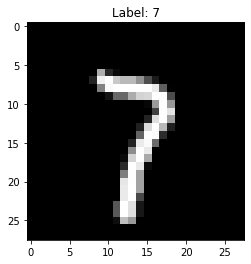

In [4]:
idx = random.randint(0, len(train_images))
plt.title(f'Label: {train_labels[idx]}')
plt.imshow(train_images[idx], cmap='gray')

In [5]:
DTYPE = np.float32

In [6]:
def relu(vector):
    vector[vector<0] = 0
    return vector

In [7]:
def relu_derivative(vector):
    vector[vector<=0] = 0.0
    vector[vector>0] = 1.0
    return vector

In [8]:
def softmax(vector):
    exp = np.exp(vector - np.max(vector))
    return exp / exp.sum()

In [9]:
def cross_entropy(predict, label):
    return -np.sum(label*np.log(predict)).astype(DTYPE)

In [10]:
def cross_entropy_derivative(predict, label):
    return (-label/predict).astype(DTYPE)

In [11]:
def softmax_derivative(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

In [32]:
class CustomMnist:
    
    def __init__(self, input_shape=(28, 28)):
        
        input_shape = input_shape[0]*input_shape[1]
        self.layer1 = np.random.uniform(-1.0, 1.0, size=(input_shape, 128))/np.sqrt(input_shape*128)
        self.layer2 = np.random.uniform(-1.0, 1.0, size=(128, 10))/np.sqrt(128*10)
        
        self.bias1 = np.random.uniform(-1.0, 1.0, size=(1, 128))/np.sqrt(128)
        self.bias2 = np.random.uniform(-1.0, 1.0, size=(1, 10))/np.sqrt(10)
        
        self.layer1 = self.layer1.astype(DTYPE)
        self.layer2 = self.layer2.astype(DTYPE)
        self.bias1 = self.bias1.astype(DTYPE)
        self.bias2 = self.bias2.astype(DTYPE)
        
    def forward(self, image):
        
        self.flatten = np.reshape(image.astype(DTYPE), (1, image.shape[0]*image.shape[1]))
        self.inter1 = np.dot(self.flatten, self.layer1) + self.bias1
        self.acti1 = relu(self.inter1)
        self.inter2 = np.dot(self.acti1, self.layer2) + self.bias2
        self.acti2 = softmax(self.inter2)
        
        return self.acti2
    
    def back_propagation(self, label):
        
        d_cross_entropy = cross_entropy_derivative(self.acti2, label)        
        self.d_softmax = np.dot(d_cross_entropy, softmax_derivative(self.acti2))
        self.d_layer2 = np.dot(self.acti1.T, self.d_softmax)
        d_acti1 = np.dot(self.d_softmax, self.layer2.T)
        self.d_relu = relu_derivative(self.acti1) * d_acti1
        self.d_layer1 = np.dot(self.flatten.T, self.d_relu)
        
    def optimize(self, lr):
        
        self.layer1 -= lr * self.d_layer1
        self.layer2 -= lr * self.d_layer2
        
        self.bias1 -= lr * self.d_relu
        self.bias2 -= lr * self.d_softmax
        
    def view(self):
        
        print('\nLayers\n----------------------------')
        print('Layer1: \t', self.layer1.shape)
        print('Layer2: \t', self.layer2.shape, end='\n\n')
        print('Flatten: \t', self.flatten.shape)
        print('Inter1: \t', self.inter1.shape)
        print('Acti1:  \t', self.acti1.shape)
        print('Inter2: \t', self.inter2.shape)
        print('Acti2:  \t', self.acti2.shape)
        
                                        
custom_mnist = CustomMnist()

EPOCHS = 10
for epoch in range(EPOCHS):
    
    b='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
    pbar = tqdm(zip(train_images[:1000], train_labels[:1000]),
                desc=f'Epochs: {epoch+1}/{EPOCHS}',
                total=len(train_images), ncols=80, bar_format=b)
    
    for image, label in pbar:
        
        label_arr = np.zeros((1, 10))
        label_arr[0][label] = 1
        
        output = custom_mnist.forward(image)
        custom_loss = cross_entropy(output, label_arr)
        custom_mnist.back_propagation(label_arr)
        custom_mnist.optimize(lr=0.01)

        pbar.set_postfix(Loss=f'{custom_loss:.4f}')
    
# custom_mnist.view()

Epochs: 10/10:   2%|▎                    | 1000/60000 [00:10<10:23, Loss=0.0029]


3
8


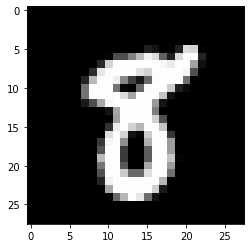

In [13]:
idx = random.randint(0, len(test_images))
a = custom_mnist.forward(test_images[idx])
print(np.argmax(a))
plt.imshow(test_images[idx], cmap='gray')
print(test_labels[idx])

In [14]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn

In [15]:
torch_train_images = torch.Tensor(np.copy(train_images))
torch_train_labels = torch.Tensor(np.copy(train_labels))

torch_dataset = TensorDataset(torch_train_images, torch_train_labels)
torch_dataloader = DataLoader(torch_dataset)

In [16]:
class TorchMnist(nn.Module):

    def __init__(self, input_shape=(28, 28)):
        super(TorchMnist, self).__init__()
        
        self.fc1 = nn.Linear(input_shape[0]*input_shape[1], 120)
        self.fc2 = nn.Linear(120, 10)

    def forward(self, x):
        
        x = torch.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.softmax(self.fc2(x), dim=0)
        
        return x
    
torch_mnist = TorchMnist()

torch_loss = nn.CrossEntropyLoss()
torch_optimizer = torch.optim.SGD(torch_mnist.parameters(), lr=0.01)

EPOCHS = 1
for epoch in range(EPOCHS):
    
    b='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}{postfix}]'
    pbar = tqdm(torch_dataloader,
                desc=f'Epochs: {epoch+1}/{EPOCHS}',
                total=len(train_images), ncols=80, bar_format=b)
    
    for image, label in pbar:
        
        torch_optimizer.zero_grad()
        
#         print(image.shape, label.shape)
        
        output = torch_mnist(image).unsqueeze(0)
        
#         print(output)
        
        loss = torch_loss(output, label.type(torch.long))
        loss.backward()
        torch_optimizer.step()
        
#         break

        pbar.set_postfix(Loss=f'{loss:.4f}') 

Epochs: 1/1:   0%|                                           | 0/60000 [00:00<?]/home/dinesh/projects/mnist/.env/lib/python3.9/site-packages/torch/autograd/__init__.py:147: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:115.)
  Variable._execution_engine.run_backward(
Epochs: 1/1:   3%|▊                      | 2051/60000 [00:10<04:56, Loss=2.2850]


KeyboardInterrupt: 

In [19]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf 

In [20]:
tf_train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(1)
tf_test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(1)

2021-09-04 17:30:08.524987: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 376320000 exceeds 10% of free system memory.


In [21]:
print(train_images[0].shape, train_labels[0].shape)

(28, 28) ()


In [22]:
tf_mnist = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [23]:
tf_mnist.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['sparse_categorical_accuracy']
)

In [24]:
tf_mnist.fit(tf_train_dataset, epochs=1)

2021-09-04 17:30:16.689401: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 376320000 exceeds 10% of free system memory.
2021-09-04 17:30:17.025236: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 376320000 exceeds 10% of free system memory.


   51/60000 [..............................] - ETA: 2:01 - loss: 2.1781 - sparse_categorical_accuracy: 0.2941      

2021-09-04 17:30:17.738045: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


 3122/60000 [>.............................] - ETA: 1:46 - loss: 0.5900 - sparse_categorical_accuracy: 0.8341

KeyboardInterrupt: 

In [26]:
tf_mnist.evaluate(tf_test_dataset)

 4321/10000 [===========>..................] - ETA: 7s - loss: 0.4497 - sparse_categorical_accuracy: 0.8651

KeyboardInterrupt: 